# Import

In [6]:
import torch
import torch.nn as nn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load Data

In [7]:
california = fetch_california_housing()
data = california.data
targets = california.target  

scaler = StandardScaler()
data = scaler.fit_transform(data)

X_train, X_val, Y_train, Y_val = train_test_split(data, targets, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
Y_train = torch.FloatTensor(Y_train).unsqueeze(1)
Y_val = torch.FloatTensor(Y_val).unsqueeze(1)

# Model Class

In [8]:
class Regression(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, hidden3):
        super(Regression, self).__init__()
        self.W1 = nn.Parameter(torch.randn(input_dim, hidden1) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(hidden1))
        self.W2 = nn.Parameter(torch.randn(hidden1, hidden2) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(hidden2))
        self.W3 = nn.Parameter(torch.randn(hidden2, hidden3) * 0.01)
        self.b3 = nn.Parameter(torch.zeros(hidden3))
        self.W_out = nn.Parameter(torch.randn(hidden3, 1) * 0.01)
        self.b_out = nn.Parameter(torch.zeros(1))
        self.relu = nn.ReLU()

    def forward(self, X):
        x = self.relu(torch.mm(X, self.W1) + self.b1)
        x = self.relu(torch.mm(x, self.W2) + self.b2)
        x = self.relu(torch.mm(x, self.W3) + self.b3)
        x = torch.mm(x, self.W_out) + self.b_out
        return x

# Training Model

In [9]:
input_dim = X_train.shape[1]
hidden1 = 64
hidden2 = 32
hidden3 = 16
model = Regression(input_dim, hidden1, hidden2, hidden3)

criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

batch_size = 32
train_data = TensorDataset(X_train, Y_train)
val_data = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

def train_model(epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        train_losses.append(running_train_loss / len(train_loader))
        val_losses.append(running_val_loss / len(val_loader))
        
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs} : Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")
    
    return train_losses, val_losses

epochs = 100
train_losses, val_losses = train_model(epochs)

model.eval()
with torch.no_grad():
    predictions = model(X_val)
    mse = mean_squared_error(Y_val, predictions)
    mae = mean_absolute_error(Y_val, predictions)
    r2 = r2_score(Y_val, predictions)

Epoch 0/100 : Training Loss: 0.5950, Validation Loss: 0.5137
Epoch 10/100 : Training Loss: 0.3089, Validation Loss: 0.2997
Epoch 20/100 : Training Loss: 0.2886, Validation Loss: 0.2842
Epoch 30/100 : Training Loss: 0.2662, Validation Loss: 0.2929
Epoch 40/100 : Training Loss: 0.2591, Validation Loss: 0.2886
Epoch 50/100 : Training Loss: 0.2553, Validation Loss: 0.2832
Epoch 60/100 : Training Loss: 0.2503, Validation Loss: 0.2801
Epoch 70/100 : Training Loss: 0.2469, Validation Loss: 0.2799
Epoch 80/100 : Training Loss: 0.2492, Validation Loss: 0.2801
Epoch 90/100 : Training Loss: 0.2412, Validation Loss: 0.2716
Epoch 99/100 : Training Loss: 0.2370, Validation Loss: 0.2735


# Plot Data


Evaluation Metrics:
Mean Squared Error (MSE): 0.2735
Mean Absolute Error (MAE): 0.3532
R² Score: 0.7913


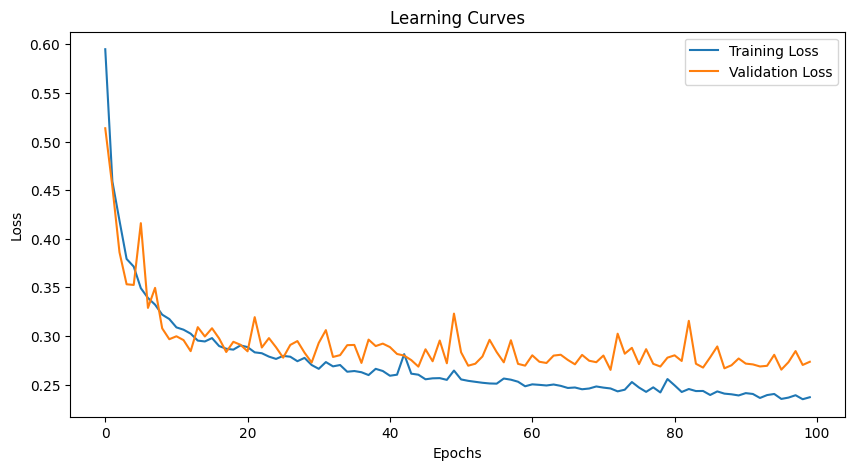

In [10]:
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curves")
plt.legend()
plt.show()